# Non-Contractual Customer Churn Prediction
#### Uma previsão de modelo de rotatividade não contratual para prever a rotatividade e identificar quais clientes estão prestes a perder, para tomada de decisões estratégicas.

*by [Bruno Azambuja](https://www.linkedin.com/in/brunoazambuja/)*


# Business Problem

Saber qual dos seus clientes vai desistir antes que isso aconteça é uma ferramenta poderosa na batalha contra a redução de performance, pois você pode agir e tentar evitá-lo. No entanto, medir a rotatividade de clientes é muito mais difícil em ambientes não contratuais. Os modelos de churn contratual podem usar técnicas regulares de classificação de aprendizado de máquina, mas os modelos de churn não contratuais exigem uma abordagem especializada devido a esse desgaste não observado do cliente.

Ao contrário dos modelos de churn contratual, os modelos de churn não contratuais precisam ser capazes de prever se um cliente está "vivo" ou "morto" (para usar a terminologia comum Customer Lifetime Value) com base em seu comportamento histórico de compra. O modelo mais comumente usado para lidar com a previsão de rotatividade de clientes em configurações não contratuais é o modelo Beta Geometric Negative Binomial Bayes Distribution ou BG/NBD.

Uma explicação simplificada dos modelos de churn não contratuais é essencialmente que cada cliente tem uma alta probabilidade de ainda estar "vivo" depois de comprar, mas essa probabilidade diminui com o tempo. Os clientes compram em frequências diferentes, portanto, têm tempos de intercompra ou latências diferentes, mas geralmente recompram em algum lugar em torno do tempo médio de intercompra. Se um cliente ultrapassa seu tempo médio de intercompra, a probabilidade de ele deixar de ser um cliente aumenta.

# Libraries and Data

Aqui instalamos todos as bibliotecas necessárias para o estudo.

In [ ]:
pip install Lifetimes

In [ ]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
from google.colab import files
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_incremental_transactions
from lifetimes.plotting import plot_cumulative_transactions
from sklearn.metrics import mean_absolute_error, mean_squared_error

# filtrar mensagens de warning
warnings.filterwarnings('ignore')

In [ ]:
uploaded_churn = files.upload()

Saving is_churn.json to is_churn.json


`is_churn.json` este arquivo contém as 3 colunas:

* `customer_code`: id único de um cliente;
* `last_purchase_date`: data da última compra;
* `is_churn`: se o cliente for churn em 01/08/2018.

In [ ]:
churn = next(iter(uploaded_churn.values()))
churn = pd.DataFrame(json.loads(churn.decode()))
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_code       818 non-null    int64  
 1   last_purchase_date  818 non-null    object 
 2   is_churn            818 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 19.3+ KB


In [ ]:
uploaded_order = files.upload()

Saving orders.json to orders.json


`orders.json` contém os pedidos feitos pelos clientes em um de nossos aplicativos entre '2008-Jan-04' e '2018-Julho-08'. Esses clientes não têm nenhum contrato ou associação com a empresa e podem interromper ou reiniciar as compras à vontade. Aqui está a descrição de cada coluna:

* `customer_code`: id único de um cliente;
* `branch_id`: o id da filial onde este pedido foi feito;
* `sales_channel`: o canal de vendas em que o pedido foi feito;
* `seller_code`: endedor que fez este pedido;
* `register_date`: data do pedido;
* `total_price`: preço total do pedido (soma do preço de todos os itens);
* `order_id`: id deste pedido. Um pedido é formado por um conjunto de itens;
* `quantity`: quantidade de itens (de item_code) comprados;
* `item_code`: código do item;
* `item_total_price`: preço total dos itens (do item_code), ou seja, quantidade x unit_price;
* `unit_price`: preço unitário deste item (do item_code);
* `group_code`: grupo ao qual o cliente pertence;
* `segment_code`: segmento ao qual o cliente pertence.

In [ ]:
orders = next(iter(uploaded_order.values()))
orders = pd.DataFrame(json.loads(orders.decode()))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204428 entries, 0 to 204427
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_code     204428 non-null  int64  
 1   branch_id         204428 non-null  int64  
 2   sales_channel     204428 non-null  int64  
 3   seller_code       204428 non-null  int64  
 4   register_date     204428 non-null  object 
 5   total_price       204428 non-null  float64
 6   order_id          204428 non-null  int64  
 7   quantity          204428 non-null  int64  
 8   item_code         204428 non-null  int64  
 9   item_total_price  204428 non-null  float64
 10  unit_price        204428 non-null  float64
 11  group_code        204428 non-null  int64  
 12  segment_code      204428 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 20.3+ MB


Analisando estes dois arquivos podemos observar que ambos contêm informações relevantes para o desenvolvimento do modelo proposto, assim como para a análise exploratória. Sendo assim, para facilitar todo o trabalho, os dados foram unificados em um único dataframe, considerando a coluna de referência `customer_code`.

In [ ]:
df_churn = orders.merge(churn.groupby(['customer_code'])['last_purchase_date','is_churn'].min().reset_index(), how='inner', on=['customer_code'])
df_churn['last_purchase_date'] = pd.to_datetime(df_churn.last_purchase_date).astype("datetime64[ns]") 
df_churn['register_date'] = pd.to_datetime(df_churn.register_date).astype("datetime64[ns]") 
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202513 entries, 0 to 202512
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_code       202513 non-null  int64         
 1   branch_id           202513 non-null  int64         
 2   sales_channel       202513 non-null  int64         
 3   seller_code         202513 non-null  int64         
 4   register_date       202513 non-null  datetime64[ns]
 5   total_price         202513 non-null  float64       
 6   order_id            202513 non-null  int64         
 7   quantity            202513 non-null  int64         
 8   item_code           202513 non-null  int64         
 9   item_total_price    202513 non-null  float64       
 10  unit_price          202513 non-null  float64       
 11  group_code          202513 non-null  int64         
 12  segment_code        202513 non-null  int64         
 13  last_purchase_date  202513 no

# Preprocessing

####**Characteristics**

Aqui podemos visualizar com mais detalhes o *dataframe*, ele contém 202.513 ocorrências de compra de produtos em momentos específicos, além disso podemos verificar a existência de 15 *features* que informam as operações com mais detalhes. Antes de iniciar as transformações necessárias, vamos verificar a qualidade deste dataframe, assim como as características específicas comportamentais das transações ao longo do tempo.

In [ ]:
df_churn

,customer_code,branch_id,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code,last_purchase_date,is_churn
0,347,0,0,106,2018-01-22,2868.41,22589,2,1608,170.55,72.90,0,0,2018-06-28,0.0
1,347,0,0,106,2018-06-28,1504.28,24532,4,1568,109.21,23.34,0,0,2018-06-28,0.0
2,347,0,0,106,2017-10-23,1012.87,21598,4,2154,308.26,65.88,0,0,2018-06-28,0.0
3,347,0,0,106,2017-10-23,1012.87,21598,8,282,209.25,22.36,0,0,2018-06-28,0.0
4,347,0,0,106,2018-01-22,2868.41,22589,3,1786,55.20,15.73,0,0,2018-06-28,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202508,327,0,6,247,2018-03-02,629.90,23242,5,2137,640.83,125.98,0,0,2018-03-02,1.0
202509,327,0,6,247,2017-12-11,2087.03,22163,16,2624,296.78,18.01,0,0,2018-03-02,1.0
202510,327,0,6,247,2017-12-11,2087.03,22163,29,1767,1830.06,62.03,0,0,2018-03-02,1.0
202511,327,0,6,247,2018-01-05,5745.88,22332,29,1778,1537.98,52.13,0,0,2018-03-02,1.0


Podemos observar que o *dataframe* está não há dados ausentes em suas respectivas *features*.

In [ ]:
df_churn.isnull().sum()

customer_code         0
branch_id             0
sales_channel         0
seller_code           0
register_date         0
total_price           0
order_id              0
quantity              0
item_code             0
item_total_price      0
unit_price            0
group_code            0
segment_code          0
last_purchase_date    0
is_churn              0
dtype: int64

Analisando as datas das operações de compras do *dataframe* conseguir descobrir a data da primeira transação, assim como da última, esta informações será importante no desenvolvimento deste modelo, assim como o número de clientes únicos contidos na base de dados.

In [ ]:
print(f"Unique number of customers: {df_churn['customer_code'].nunique():,.0f}")
print(f"Min. transaction date: {df_churn['last_purchase_date'].min().date()}")
print(f"Max. transaction date: {df_churn['last_purchase_date'].max().date()}")

Unique number of customers: 818
Min. transaction date: 2009-05-19
Max. transaction date: 2018-07-08


Aqui podemos observar o padrão comportamental de compras ao longo do tempo. Os dados contidos no gráfico indicam uma variabilidade de compra entre dias bem elevada, porém podemos observar um aumento gradual entre os picos máximos ao longo do tempo.

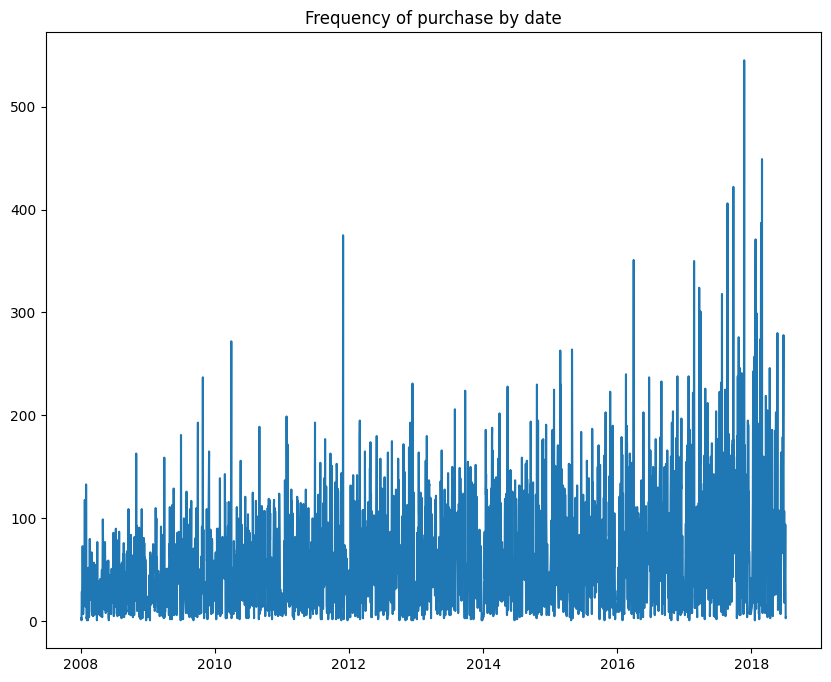

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(df_churn.groupby(['register_date'])['customer_code'].count())
plt.title("Frequency of purchases by date")
plt.show()

Já neste gráfico podemos observar as mesmas transações, porém de forma agrupada.

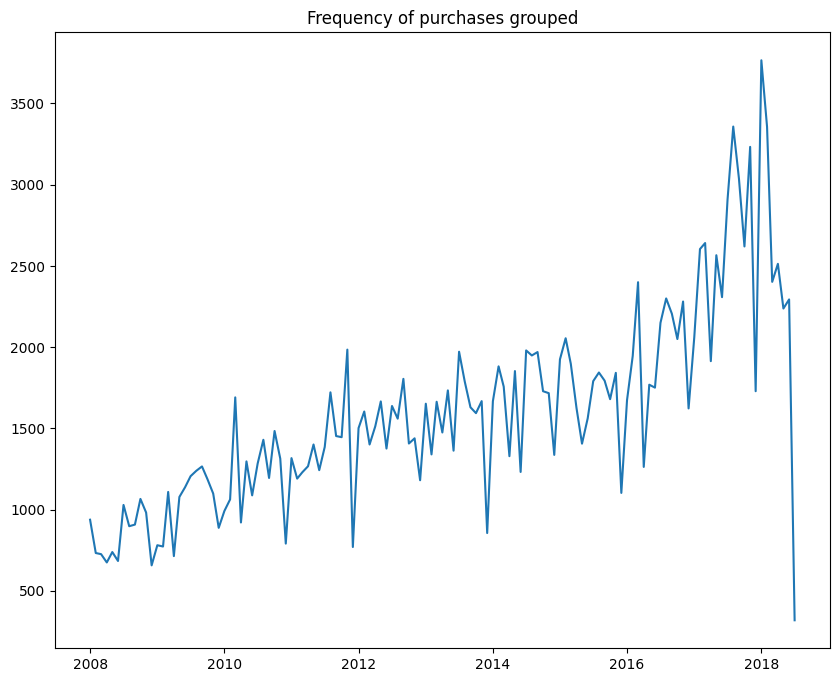

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(df_churn
         .assign(transaction_month=lambda x: x['register_date'].dt.strftime('%Y-%m-01').astype(np.datetime64))
         .groupby(['transaction_month'])['customer_code']
         .count()
        )
plt.title("Frequency of purchases grouped")
plt.show()

####**Feature Engineering**

A modelagem de churn requer o uso de dados brutos não discretizados de recência, frequência e posse/idade. O pacote `Lifetimes` inclui um função útil chamada `summary_data_from_transaction_data()` que permite calcular eles rapidamente, além do valor monetário dos clientes. Desta forma os dados de clientes ficaram estruturados da seguinte forma:

* `frequência`: representa o número de compras repetidas que o cliente fez, ou seja frequência em que um cliente fez uma compra. É a contagem de períodos de tempo em que o cliente fez uma compra;
* `recência`: representa a idade do cliente quando fez suas compras mais recentes. Isso é igual à duração entre a primeira compra de um cliente e sua última compra;
* `T`: representa a posse/idade do cliente em quaisquer unidades de tempo escolhidas (semanal, no conjunto de dados acima). Isso é igual à duração entre a primeira compra de um cliente e o final do período em estudo;
* `monetary_value`: representa o valor médio das compras de um determinado cliente. Isso é igual à soma de todas as compras de um cliente dividida pelo número total de compras.

In [ ]:
df_customer = summary_data_from_transaction_data(df_churn, 'customer_code', 'register_date', 'total_price', observation_period_end='2018-07-08')
df_customer

,frequency,recency,T,monetary_value
customer_code,,,,
0,18.0,3545.0,3575.0,38927.116667
1,41.0,3667.0,3785.0,25110.157073
2,38.0,3810.0,3820.0,21599.122105
3,61.0,3722.0,3783.0,83068.862459
4,34.0,3617.0,3788.0,30782.407647
...,...,...,...,...
832,25.0,2539.0,2628.0,26852.964400
833,25.0,2495.0,2603.0,67184.411200
835,3.0,735.0,2558.0,11424.316667


# Exploratory Data Analysis (EDA)

Examinando as distribuições estatísticas dos dados de recência, frequência, valor monetáro e posse/idade mostra o quadro geral de grande concentração de dados em cada respectiva métrica.

####**Recency**

Podemos observar um grande número de clientes mais antigos, já sobre os demais níveis de recência há uma quantidade em patamares similares.

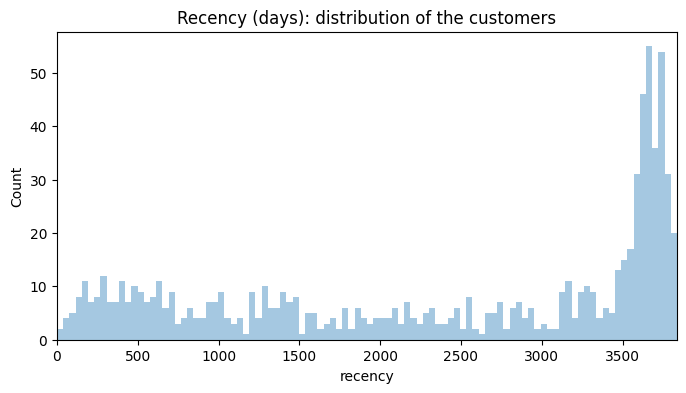

In [ ]:
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_customer["recency"], bins=100, kde=False)
ax.set_xlim(0, df_customer["recency"].max())
ax.set(ylabel = 'Count')
ax.set_title("Recency (days): distribution of the customers");

A relação de recência e frequência dos clientes, foi necessária a remoção dos dados outliers, mantendo somente os que apresentaram frequência até 200. Sendo assim os dados nos mostram que o comportamento de compras dos clientes em níveis de recência maior ocorreu em maior frequência.

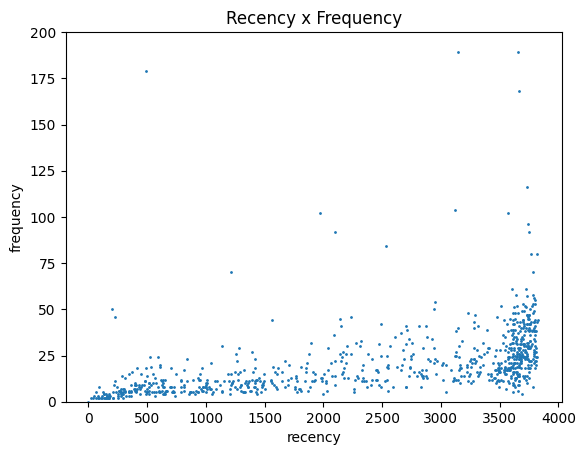

In [247]:
fig, ax = plt.subplots()
ax.scatter(x = df_customer['recency'], y = df_customer['frequency'], s=1)
plt.xlabel("recency")
plt.ylabel("frequency")
ax.set_ylim(0, 200)
ax.set_title("Recency x Frequency without outliers");

Assim como o gráfico anterior, em relação à recência e o valor monetário dos clientes, foi necessária a remoção dos dados outliers, mantendo somente os que apresentaram frequência até 200.000. Sendo assim podemos dizer que os dados nos mostram que o comportamento de compras dos clientes em todos os níveis de recência ocorreu em faixas de valores similares.

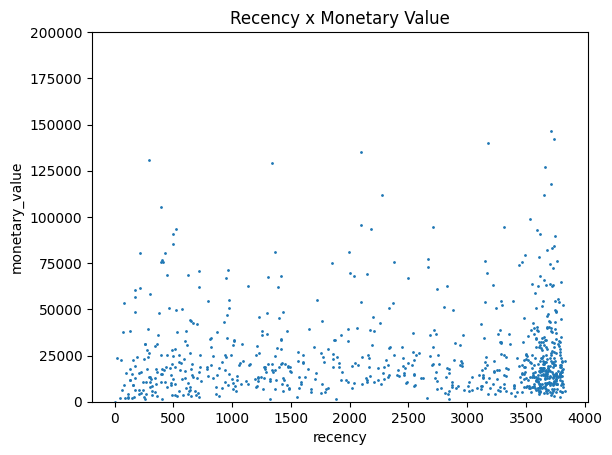

In [250]:
fig, ax = plt.subplots()
ax.scatter(x = df_customer['recency'], y = df_customer['monetary_value'], s=1)
plt.xlabel("recency")
plt.ylabel("monetary_value")
ax.set_ylim(0, 200000)
ax.set_title("Recency x Monetary Value");

####**Frequency**

Aqui podemos ver que a maior parte dos clientes realizam compras com menor frequência, sendo ue a maior parte deles está dentro da faixa de 100. Porém conforme os dados anteriores, este também apresentam poucos dados considerados outliers.

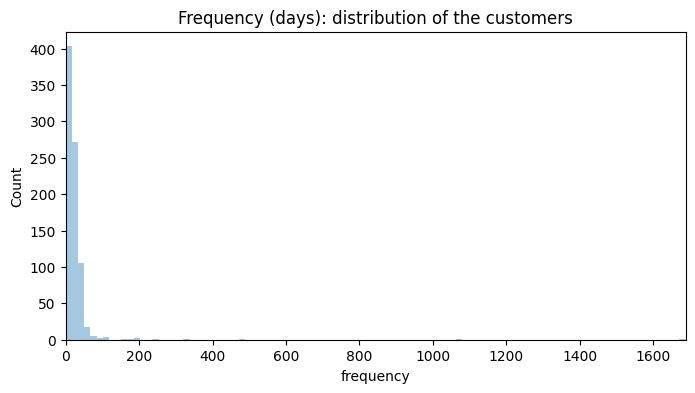

In [252]:
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_customer["frequency"], bins=100, kde=False)
ax.set_xlim(0, df_customer["frequency"].max())
ax.set(ylabel = 'Count')
ax.set_title("Frequency (days): distribution of the customers");

Removendo os valores monetários outliers acima de 200.000 podemos ver, conforme já mencionei anteriormente, que há uma maior concentração de compras dentre valores menores.

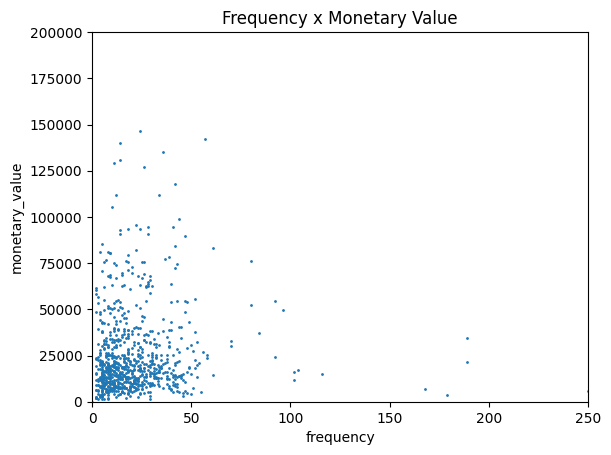

In [253]:
fig, ax = plt.subplots()
ax.scatter(x = df_customer['frequency'], y = df_customer['monetary_value'], s=1)
plt.xlabel("frequency")
plt.ylabel("monetary_value")
ax.set_xlim(0, 250)
ax.set_ylim(0, 200000)
ax.set_title("Frequency x Monetary Value");

####**Monetary Value**

Aqui podemos observar que há uma maior concentração de clientes com compras entre 5.000 e 25.000, para visualizar isso foi necessária a remoção dos outliers acima de 90.000.

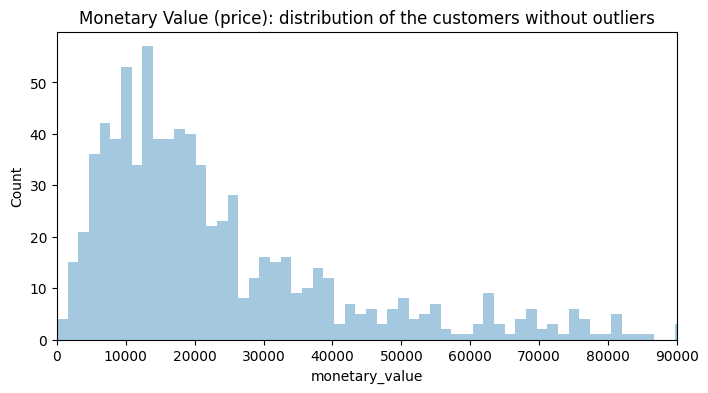

In [262]:
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_customer["monetary_value"], bins=1000, kde=False)
ax.set_xlim(0, 90000)
ax.set(ylabel = 'Count')
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_title("Monetary Value (price): distribution of the customers without outliers");

####**Tenure**

Aqui o gráfico nos mostra que a maior parte dos clientes é composta por clientes mais antigos.

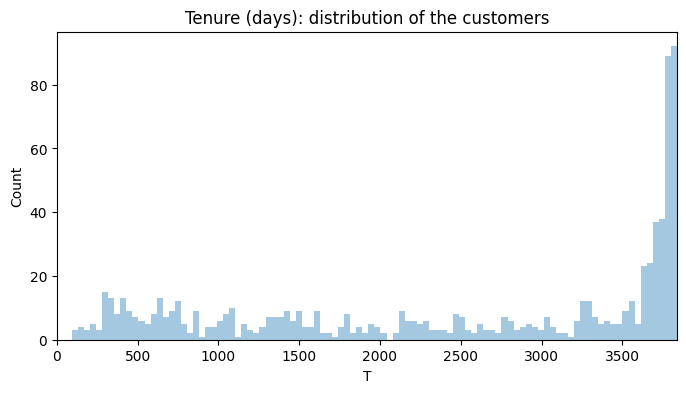

In [ ]:
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_customer["T"], bins=100, kde=False)
ax.set_xlim(0, df_customer["T"].max())
ax.set(ylabel = 'Count')
ax.set_title("Tenure (days): distribution of the customers");

#BG/NBD Model - Low Holdout Group

Vamos usar o modelo Beta-Geométrico/NBD (BG/NBD) para churn de clientes. O modelo BG/NBD é uma adaptação do modelo de Pareto/NBD. Ambos os modelos descrevem padrões de compra repetidos em empresas onde a rotatividade de clientes não é observada, no entanto, o BG/NBD é muito mais viável computacionalmente.

Pressupostos do modelo BG/NBD:

* O relacionamento de um cliente tem duas fases: "vivo" por um período de tempo não observado, depois "morto";
* Enquanto vivo, o número de transações feitas por um cliente segue uma distribuição de Poisson com taxa de transação lambda;
* A heterogeneidade em lambda segue uma distribuição gama;
* Após qualquer transação, um cliente morre com probabilidade p; A probabilidade de um cliente morrer após um número de transações segue uma distribuição geométrica;
* O p segue uma distribuição beta;
* O lambda e o p variam independentemente entre os clientes.

####**Holdout group**

Para tornar o modelo um mais robusto, é uma boa prática adicionar um grupo de holdouts. Isso treina o modelo em um período de calibração (ou treinamento) e, em seguida, faz previsões para o período de observação (ou teste), usando dados que foram mantidos que o modelo nunca viu.

A ideia é essencialmente como "backcasting", onde as previsões são feitas contra um período para o qual você conhece os resultados, antes de colocar o modelo em produção.

In [263]:
summary_cal_holdout_1 = calibration_and_holdout_data(df_churn, 
                                                   'customer_code', 
                                                   'register_date',
                                                    calibration_period_end='2018-06-08',
                                                    observation_period_end='2018-07-08')
summary_cal_holdout_1.sort_values(by='frequency_holdout', ascending=True)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_code,,,,,
0,18.0,3545.0,3545.0,0.0,30.0
522,21.0,3684.0,3706.0,0.0,30.0
523,10.0,1223.0,1241.0,0.0,30.0
524,92.0,3750.0,3781.0,0.0,30.0
525,23.0,2415.0,2555.0,0.0,30.0
...,...,...,...,...,...
413,38.0,197.0,197.0,8.0,30.0
415,41.0,178.0,178.0,9.0,30.0
633,1056.0,3286.0,3286.0,12.0,30.0


####**Fitting model**

Para criar o modelo BG/NBD inicial, podemos instanciar a classe, ajustar o modelo e treiná-lo usando os dados de frequência, recência e idade/posse com o `BetaGeoFitter()`. Temos também o resumo do modelo indicando a divisão dos coeficientes do modelo com o `summary`.

In [264]:
# BG/NBD model fit on whole dataset
bgf1 = BetaGeoFitter(penalizer_coef = 0.00000001)
bgf1.fit(frequency = summary_cal_holdout_1["frequency_cal"], recency = summary_cal_holdout_1["recency_cal"], T = summary_cal_holdout_1["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 818 subjects, a: 0.00, alpha: 130.78, b: 4.86, r: 1.52>

In [265]:
bgf1.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.519953,0.074549,1.373836,1.666070
alpha,130.779210,7.699869,115.687467,145.870953
a,0.000890,0.001541,-0.002131,0.003910
b,4.859451,12.478026,-19.597481,29.316383


####**Model diagnostics**

Este gráfico conhecido como Purchases Calibration vs Holdout Purchases, nele podemos ver a frequência de compras que o modelo previu no período de retenção versus os dados reais. Como podemos ver, o modelo está distante.

Desta forma, iremos seguir aumentando o grupo de retenção avaliando a suas respectivas performances.

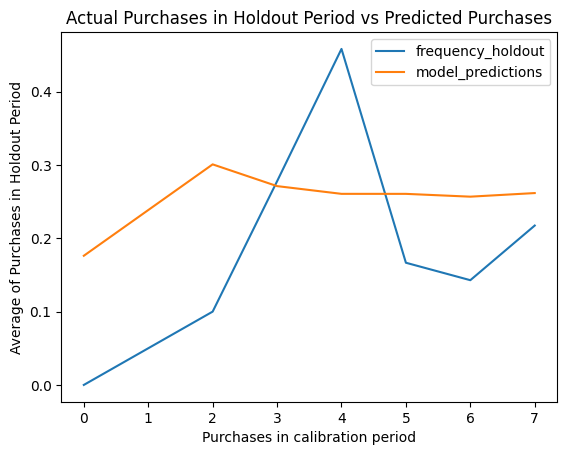

In [297]:
plot_calibration_purchases_vs_holdout_purchases(bgf1, summary_cal_holdout_1);

Este é o gráfico de transações cumulativa, podemos avaliar como o conjunto de dados funciona plotando ambos, tanto os atuais como os da previsões. A linha vermelha representa o limite entre o período de calibração à esquerda e o período de retenção à direita. Como você pode ver, o modelo BG/NBD faz um bom trabalho na previsão de transações cumulativas.

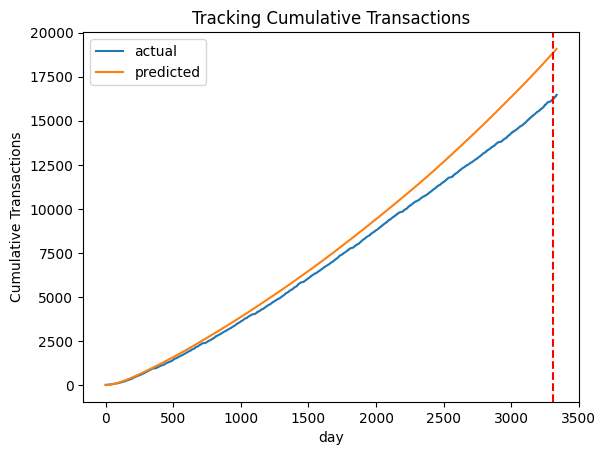

In [266]:
plot_cumulative_transactions(bgf1, df_churn, 'register_date', 'customer_code', 3337, 3307);

Este gráfico, conhecido como gráfico de transação incremental, nos mostra que o modelo faz um trabalho adequado capturando tendências gerais nos dados.

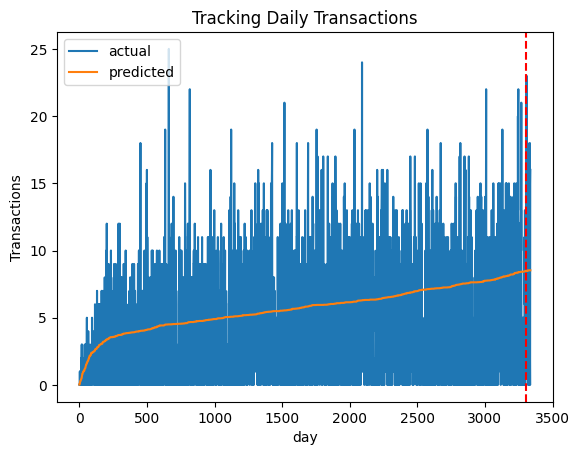

In [267]:
plot_incremental_transactions(bgf1, df_churn, 'register_date', 'customer_code', 3337, 3307);

#BG/NBD Model - Medium Holdout Group

####**Holdout group**

Para tornar o modelo um pouco mais robusto, é uma boa ideia adicionar um grupo maior de holdouts.

In [272]:
summary_cal_holdout_2 = calibration_and_holdout_data(df_churn, 
                                                   'customer_code', 
                                                   'register_date',
                                                    calibration_period_end='2017-07-08',
                                                    observation_period_end='2018-07-08')
summary_cal_holdout_2.sort_values(by='frequency_holdout', ascending=True)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_code,,,,,
835,3.0,735.0,2193.0,0.0,365.0
730,5.0,300.0,3272.0,0.0,365.0
445,12.0,2543.0,3392.0,0.0,365.0
99,4.0,982.0,1046.0,1.0,365.0
122,5.0,868.0,941.0,1.0,365.0
...,...,...,...,...,...
644,427.0,3459.0,3469.0,49.0,365.0
633,969.0,2950.0,2951.0,99.0,365.0
422,50.0,127.0,128.0,129.0,365.0


####**Fitting model**

Aqui com os dados com houldout um pouco maior, retreinamos o modelo para que, na sequência, possamos avaliar as suas respectivas performances.

In [273]:
bgf2 = BetaGeoFitter(penalizer_coef = 0.00000001)
bgf2.fit(summary_cal_holdout_2['frequency_cal'], 
        summary_cal_holdout_2['recency_cal'], 
        summary_cal_holdout_2['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 770 subjects, a: 0.02, alpha: 144.14, b: 138.84, r: 1.52>

In [274]:
bgf2.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.515482,0.079503,1.359655,1.671308
alpha,144.139337,8.991480,126.516036,161.762637
a,0.024060,0.030169,-0.035072,0.083192
b,138.839069,161.119379,-176.954914,454.633051


####**Model dignostics**

Como podemos ver, os ajustes propostos tornaram o modelo e seus respectivos dados previstos um pouco mais próximos aos reais.

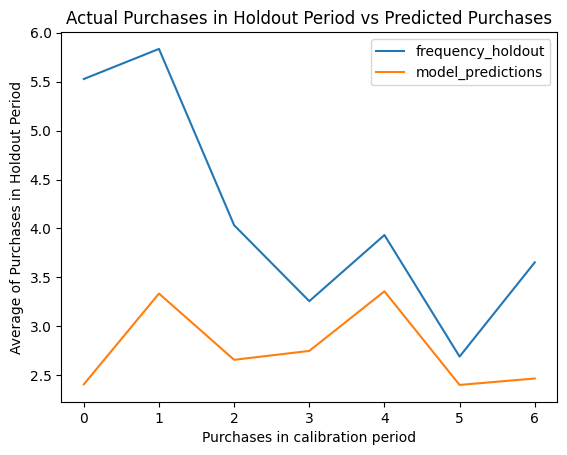

In [275]:
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout_2);

Aqui como podemos ver, este modelo é mais ajustado, ficando os dados previstos mais próximos aos atuais.

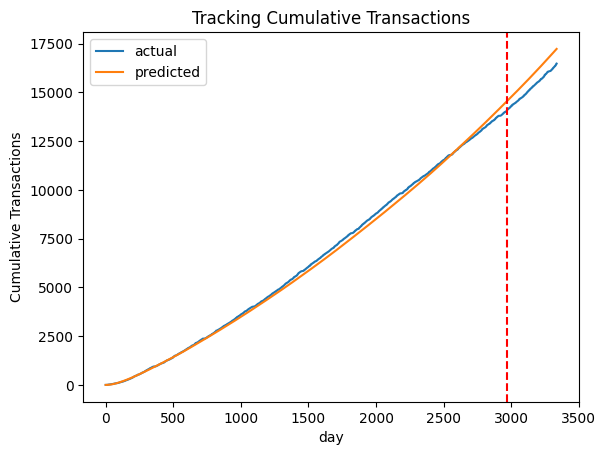

In [276]:
plot_cumulative_transactions(bgf2, df_churn, 'register_date', 'customer_code', 3337, 2972);

Este gráfico nos mostra que o modelo continua fazendo um bom trabalho, capturando tendências gerais nos dados.

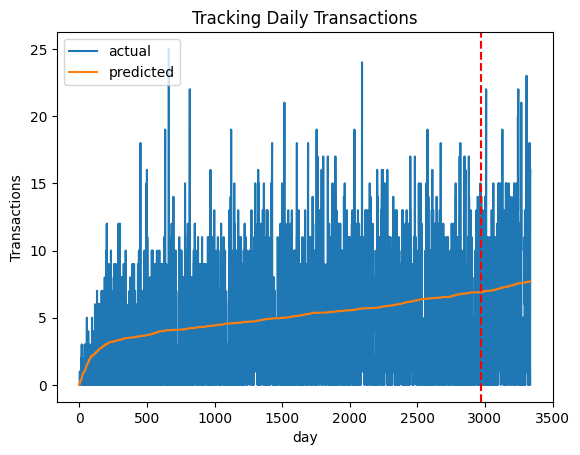

In [277]:
plot_incremental_transactions(bgf2, df_churn, 'register_date', 'customer_code', 3337, 2972);

#BG/NBD Model - High Holdout Group

####**Extend holdout group**

Para tornar o modelo ainda um pouco mais robusto, adicionar um grupo pouco maior de holdouts.

In [278]:
summary_cal_holdout_3 = calibration_and_holdout_data(df_churn, 
                                                   'customer_code', 
                                                   'register_date',
                                                    calibration_period_end='2016-07-08',
                                                    observation_period_end='2018-07-08')
summary_cal_holdout_3.sort_values(by='frequency_holdout', ascending=True)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_code,,,,,
730,5.0,300.0,2907.0,0.0,730.0
835,3.0,735.0,1828.0,0.0,730.0
445,12.0,2543.0,3027.0,0.0,730.0
286,9.0,2268.0,2520.0,2.0,730.0
408,11.0,2874.0,3045.0,2.0,730.0
...,...,...,...,...,...
763,143.0,2510.0,2528.0,46.0,730.0
658,282.0,2551.0,2565.0,48.0,730.0
644,356.0,3097.0,3104.0,120.0,730.0


####**Fitting model**

Aqui com os dados com houldout um pouco maior, retreinamos o modelo para que, na sequência, possamos avaliar as suas respectivas performances.

In [279]:
bgf3 = BetaGeoFitter(penalizer_coef = 0.00000001)
bgf3.fit(summary_cal_holdout_3['frequency_cal'], 
        summary_cal_holdout_3['recency_cal'], 
        summary_cal_holdout_3['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 687 subjects, a: 0.08, alpha: 156.44, b: 130.20, r: 1.52>

In [280]:
bgf3.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.518879,0.084430,1.353396,1.684363
alpha,156.439978,10.044018,136.753703,176.126253
a,0.081233,0.086023,-0.087371,0.249838
b,130.203581,141.477943,-147.093187,407.500350


####**Model diagnostics**

Como podemos ver os ajustes propostos tornaram o modelo e seus respectivos dados previstos um pouco mais próximos aos reais.

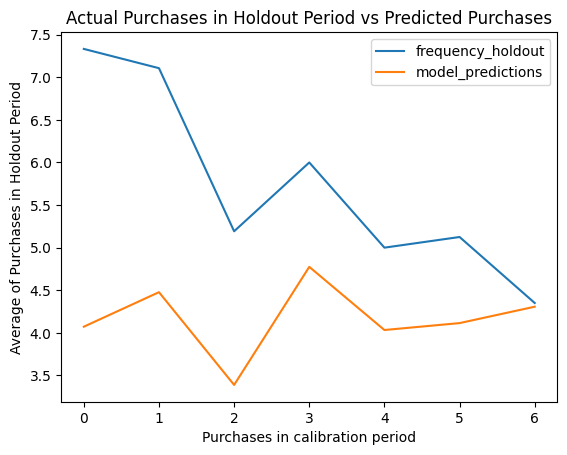

In [281]:
plot_calibration_purchases_vs_holdout_purchases(bgf3, summary_cal_holdout_3);

Aqui como podemos ver, este modelo é o mais ajustado, ficando os dados previstos ainda mais próximos aos atuais.

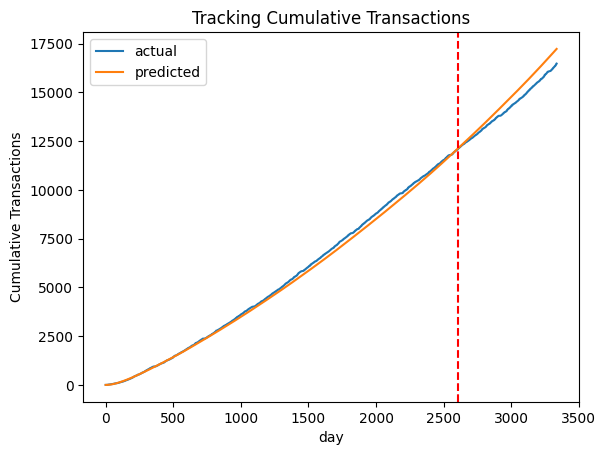

In [282]:
plot_cumulative_transactions(bgf2, df_churn, 'register_date', 'customer_code', 3337, 2607);

Este gráfico nos mostra que o modelo continua fazendo um bom trabalho, capturando tendências gerais nos dados.

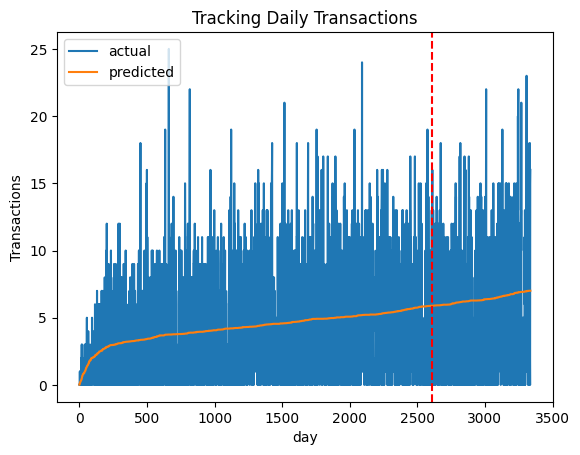

In [283]:
plot_incremental_transactions(bgf3, df_churn, 'register_date', 'customer_code', 3337, 2607);

# Evaluation criteria

####**Model Selection**

A fim de conseguirmos selecionar o modelo com o melhor ajuste de forma mais objetiva e que atende de forma mais satisfatória os objetivos propostos iremos avaliar tanto o MAE como o RMSE score, estas métricas nos indicam as seguintes pontos:

* `Erro absoluto médio (MAE)`: é outra medida de quão longe os valores previstos estão dos valores observados, assim, quanto menor esse valor, melhor. Diferentemente do RMSE, essa métrica não penaliza tão severamente os erros maiores e outliers;

* `Raiz do quadrado médio (RMSE)`: é essencialmente uma medida de quão espalhados esses resíduos estão, e é uma maneira padrão de quantificar o erro geral para um modelo, quanto menor seu valor, melhor é o modelo. Uma desvantagem potencial desta métrica é que, devido ao método de cálculo, penalizará grandes erros e outliers mais do que outras métricas.

Primeiramente fazemos a previsão do modelo sobre os dados gerados anteriormente, para que, na sequência, possamos calcular as respectivas métricas.

**BG/NBD Model - Low Holdout Group**

In [285]:
summary_cal_holdout_1["frequency_model_pred"] = bgf1.predict(t = 3337, frequency = summary_cal_holdout_1['frequency_cal'], recency = summary_cal_holdout_1['recency_cal'], T = summary_cal_holdout_1['T_cal'])
summary_cal_holdout_1.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency_model_pred
customer_code,,,,,,
0,18.0,3545.0,3545.0,0.0,30.0,17.715012
1,41.0,3667.0,3755.0,0.0,30.0,36.502412
2,37.0,3683.0,3790.0,1.0,30.0,32.773067
3,61.0,3722.0,3753.0,0.0,30.0,53.700984
4,34.0,3617.0,3758.0,0.0,30.0,30.468566


In [286]:
print('Pareto/NBD Model Score:')
print(f'MAE score: {mean_absolute_error(df_customer.dropna()["frequency"], df_customer.dropna()["frequency_model_pred"]):,.2f}')
print(f'RMSE score: {mean_squared_error(df_customer.dropna()["frequency"], df_customer.dropna()["frequency_model_pred"], squared = False):,.2f}')

Pareto/NBD Model Score:
MAE score: 16.80
RMSE score: 50.35


**BG/NBD Model - Medium Holdout Group**

In [287]:
summary_cal_holdout_2["frequency_model_pred"] = bgf2.predict(t = 3337, frequency = summary_cal_holdout_2['frequency_cal'], recency = summary_cal_holdout_2['recency_cal'], T = summary_cal_holdout_2['T_cal'])
summary_cal_holdout_2.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency_model_pred
customer_code,,,,,,
0,15.0,3118.0,3210.0,3.0,365.0,16.405470
1,38.0,3332.0,3420.0,3.0,365.0,36.894595
2,34.0,3362.0,3455.0,4.0,365.0,32.844326
3,58.0,3380.0,3418.0,3.0,365.0,55.564602
4,33.0,3348.0,3423.0,1.0,365.0,32.208733


In [288]:
print('Pareto/NBD Model Score - Add Holdout Group:')
print(f'MAE score: {mean_absolute_error(summary_cal_holdout_2.dropna()["frequency_cal"], summary_cal_holdout_2.dropna()["frequency_model_pred"]):,.2f}')
print(f'RMSE score: {mean_squared_error(summary_cal_holdout_2.dropna()["frequency_cal"], summary_cal_holdout_2.dropna()["frequency_model_pred"], squared = False):,.2f}')

Pareto/NBD Model Score - Add Holdout Group:
MAE score: 13.15
RMSE score: 35.93


**BG/NBD Model - Hight Holdout Group**

In [289]:
summary_cal_holdout_3["frequency_model_pred"] = bgf3.predict(t = 3337, frequency = summary_cal_holdout_3['frequency_cal'], recency = summary_cal_holdout_3['recency_cal'], T = summary_cal_holdout_3['T_cal'])
summary_cal_holdout_3.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency_model_pred
customer_code,,,,,,
0,12.0,2789.0,2845.0,6.0,730.0,14.952752
1,35.0,3016.0,3055.0,6.0,730.0,37.582137
2,30.0,3066.0,3090.0,8.0,730.0,32.121987
3,56.0,3045.0,3053.0,5.0,730.0,59.062526
4,31.0,2943.0,3058.0,3.0,730.0,33.428623


In [290]:
print('Pareto/NBD Model Score - Add Holdout Group:')
print(f'MAE score: {mean_absolute_error(summary_cal_holdout_3.dropna()["frequency_cal"], summary_cal_holdout_3.dropna()["frequency_model_pred"]):,.2f}')
print(f'RMSE score: {mean_squared_error(summary_cal_holdout_3.dropna()["frequency_cal"], summary_cal_holdout_3.dropna()["frequency_model_pred"], squared = False):,.2f}')

Pareto/NBD Model Score - Add Holdout Group:
MAE score: 10.16
RMSE score: 16.88


As métricas geradas pelos modelos mostra que o modelo que apresentou o menor erro é o terceiro, nomeado como `Pareto/NBD Model Score - Add Holdout Group`. Com isso seguiremos a análise dos dados previstos por este modelo a fim de nos aprofundarmos um mais em seus insights.

####**Probability Alive Matrix**

Para examinar todos os clientes e ver como a recência e a frequência histórica afetam a probabilidade de os clientes estarem vivos ou terem se movimentado, podemos plotar os dados em uma matriz de mapa de calor usando a função `plot_probability_alive_matrix()`.

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

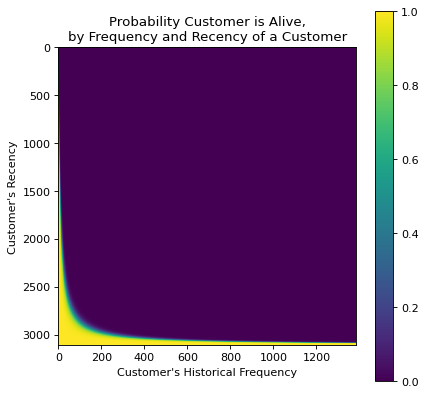

In [291]:
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plot_probability_alive_matrix(bgf3)

####**Prediction Probability Alive**

A outra coisa que pode examinar é a probabilidade de churn individual de um cliente. Isso é muito poderoso em decisões estratégicas de marketing. Os dados abaixo mostram o comportamento histórico dos clientes, para isso usaremos a função conhecida como `conditional_probability_alive()`.

In [293]:
# probability that a customer is alive for each customer in dataframe at the max date
summary_cal_holdout_3["prob_alive_pred"]  = bgf3.conditional_probability_alive(frequency = summary_cal_holdout_3["frequency_cal"], recency = summary_cal_holdout_3["recency_cal"], T = summary_cal_holdout_3["T_cal"])
summary_cal_holdout_3.sort_values(by='prob_alive_pred', ascending=True).dropna().head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,frequency_model_pred,prob_alive_pred
customer_code,,,,,,,
730,5.0,300.0,2907.0,0.0,730.0,0.047360,0.006686
350,13.0,1237.0,3089.0,5.0,730.0,0.120406,0.008101
776,97.0,2128.0,2415.0,7.0,730.0,2.945105,0.023491
769,10.0,918.0,2479.0,7.0,730.0,0.765292,0.052702
811,26.0,1505.0,2081.0,6.0,730.0,14.065933,0.346205


####**Prediction History Alive**

O gráfico abaixo no mostra o comportamento histórico de um cliente aleatório, fornecido pela função `plot_history_alive`. Cada linha vermelha corresponde a um pedido feito por um cliente, com a linha azul representando sua probabilidade de estar "vivo" ou "morto". Como você pode ver, esse cliente geralmente faz pedidos com bastante regularidade, mas tem alguns intervalos sazonais mais longos.

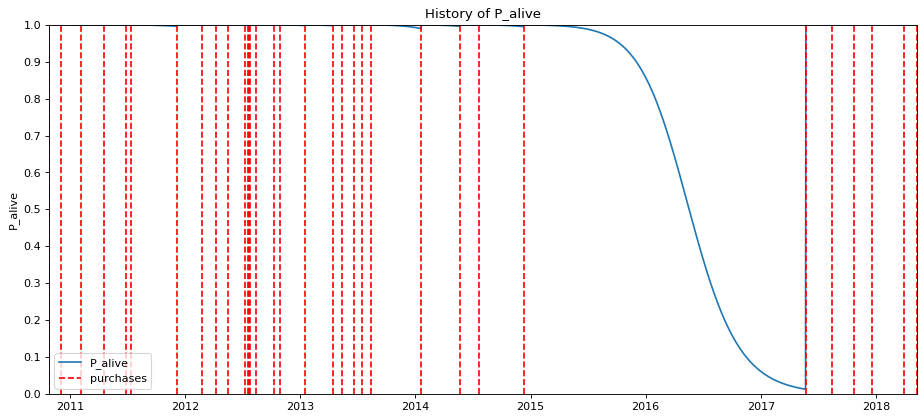

In [294]:
# selecionando exemplo de cliente
example_customer_orders = df_churn.loc[df_churn['customer_code'] == 811]
example_customer_orders.sort_values(by='register_date', ascending=True)

# gerando a curva de previsão
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
days_since_birth = 118
plot_history_alive(bgf3, days_since_birth, example_customer_orders, 'register_date');

####**Prediction Order Numbers Next Year**

Como o modelo examina o comportamento de compra histórico de cada cliente, bem como sua probabilidade de estar vivo, também podemos prever quantos pedidos cada cliente fará no próximo período (definido como 90 dias no meu exemplo abaixo).

In [300]:
t = 90
individual = df_customer.loc[811]
bgf3.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.0153311080611545

# Conclusion

O modelo desenvolvido nos indica a probabilidade do clientes se manter vivo e ele também faz uma previsão de quantos pedidos cada cliente pode fazer. Neste modelo desenvolvido obtivemos um desempenho em um patamar satisfatório, atendendo os objetivos propostos inicialmente neste estudo.

O desenvolvimento do modelo baseado na métrica `MAE` e `RMSE` proporcionou uma melhoria significativa de desempenho conforme ajustamos o *holdout group*, desta forma aumentamos significativamente as chances de reduzirmos os prejuízos do negócio com a aplicação de técnicas de desenvolvimento de algoritmos.

Além disso, a *exploratoty data analysis (EDA)* proporcionou insights relevantes que contribuíram para o desenvolvimento de um modelo com uma melhor performance. Com este estudo podemos gerar diversos insights valiosos de marketing.

O objetivo deste estudo não é abordar as estratégias de marketing que podemos usar para reter clientes que identificamos como propensos a churn, mas recomendo que seja feita a análise das possíveis razões para churn para ver se consegue identificar a causa e definir ações concretas para isso a fim de melhorar a performance de negócio.

Para sermos capazes de replicar a análise a partir do código-fonte, explicitei todas as versões das ferramentas e os pacotes que foram usadas, assim como os demais.

In [296]:
pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
defusedxml==0.7.1
dill==0.3.6
distributed==2022.12.1
d